In [25]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

In [22]:
def tif2array(file_path, dtype=np.float32):
    """
    read GeoTiff and convert to numpy.ndarray.
    inputs:
        file_path (str) : file path of the input GeoTiff file
    return:
        image(np.array) : image for each bands
        dataset : for gdal's data drive
    """
    dataset = gdal.Open(file_path, gdal.GA_ReadOnly)

    if dataset is None:
        return None

    # Allocate our array using the first band's datatype
    image_datatype = dataset.GetRasterBand(1).DataType
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=dtype)

    # Loop over all bands in dataset
    for b in range(dataset.RasterCount):
        # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
        band = dataset.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        image[:, :, b] = band.ReadAsArray()#buf_type=gdalconst.GDT_Byte)

    #image = image[2:-2,2:-2,:]

    return image

In [40]:
geo_transform={'t'}

In [41]:
if not geo_transform:
    print('full')
else:
    print('empty')

empty


In [55]:
def array2raster(newRasterfn, dataset, array, dtype, offsetX=0, offsetY=0, geo_transform=(), prj=''):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset : original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    cols = array.shape[1]
    rows = array.shape[0]
    
    if geo_transform:
        originX, pixelWidth, b, originY, d, pixelHeight = geo_transform
    else:
        originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()
        
    originX += offsetX
    originY += offsetY

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte": 
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    # setteing srs from input tif file.
    if prj == '':
        prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [3]:
data = tif2array('/mnt/data_1/dsm/diff/dsm_part_0_diff.tif')
data = tif2array('/mnt/data_1/dsm/179/FB179_ndsm.tif')
#pred = np.load('pred_deeplab.npy')

In [5]:
data

array([[[-3.4028235e+38],
        [-3.4028235e+38],
        [-3.4028235e+38],
        ...,
        [-3.4028235e+38],
        [-3.4028235e+38],
        [-3.4028235e+38]],

       [[-3.4028235e+38],
        [-3.4028235e+38],
        [-3.4028235e+38],
        ...,
        [-3.4028235e+38],
        [-3.4028235e+38],
        [-3.4028235e+38]],

       [[-3.4028235e+38],
        [-3.4028235e+38],
        [-3.4028235e+38],
        ...,
        [-3.4028235e+38],
        [-3.4028235e+38],
        [-3.4028235e+38]],

       ...,

       [[-3.4028235e+38],
        [-3.4028235e+38],
        [-3.4028235e+38],
        ...,
        [-3.4028235e+38],
        [-3.4028235e+38],
        [-3.4028235e+38]],

       [[-3.4028235e+38],
        [-3.4028235e+38],
        [-3.4028235e+38],
        ...,
        [-3.4028235e+38],
        [-3.4028235e+38],
        [-3.4028235e+38]],

       [[-3.4028235e+38],
        [-3.4028235e+38],
        [-3.4028235e+38],
        ...,
        [-3.4028235e+38],
        [-3.402

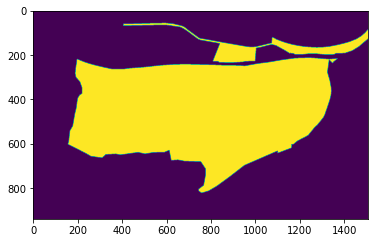

In [6]:
plt.imshow(data)

In [7]:

data[(data<15)] = 0

In [8]:
from scipy import ndimage

In [9]:
# filter data

# kernel size
s = 5
# erosion
datax = ndimage.grey_erosion(data[:,:,0], size=(s,s))
# dilation
datax = ndimage.grey_dilation(datax, size=(s,s))

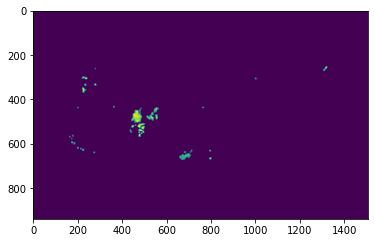

In [10]:
plt.imshow(datax)

In [51]:
newRasterfn = '/mnt/data_1/dsm/diff/dsm_part_0_filter.tif'
oldRasterfn = '/mnt/data_1/dsm/diff/dsm_part_0_diff.tif'
# open coresponding ortho file
dataset = gdal.Open(oldRasterfn, gdal.GA_ReadOnly)

#array2raster(newRasterfn, dataset, datax, dtype='Byte')

In [5]:
grid_tiles = gpd.read_file('/mnt/data_1/change_detection/grid/177/tiles_512_02_ww_ie.shp')

In [16]:
# get extend

minx = grid_tiles.bounds['minx'].min()
miny = grid_tiles.bounds['miny'].min()

maxx = grid_tiles.bounds['maxx'].max()
maxy = grid_tiles.bounds['maxy'].max()

print(minx, miny, maxx, maxy)

403635.89999971323 350719.51519992994 449029.59999971325 372184.11519993


In [ ]:
#=======================#
# clip raster by extend
#=======================#

In [18]:
# set input and output file
in_path = '/mnt/data_1/dsm/177/FB177_ndsm.tif'
out_path = '/mnt/data_1/change_detection/new_chm/FB177_ndsm.tif'

# cerate bash command
cmd = 'gdal_translate -projwin {} {} {} {} -of GTiff {} {}'.format(minx, maxy, maxx, miny, in_path, out_path)
print(cmd)

# execute bash command
os.system(cmd)

print('done')

gdal_translate -projwin 403635.89999971323 372184.11519993 449029.59999971325 350719.51519992994 -of GTiff /mnt/data_1/dsm/177/FB177_ndsm.tif /mnt/data_1/change_detection/new_chm/FB177_ndsm.tif
Input file size is 148080, 89040
0...10...20...30...40...50...60...70...80...90...100 - done.
done


In [19]:
# set input and output file
in_path = '/mnt/data_1/dsm/ndom_oa.tif'
out_path = '/mnt/data_1/change_detection/old_chm/FB177_ndsm.tif'

# cerate bash command
cmd = 'gdal_translate -projwin {} {} {} {} -of GTiff {} {}'.format(minx, maxy, maxx, miny, in_path, out_path)
print(cmd)

# execute bash command
os.system(cmd)

print('done')

gdal_translate -projwin 403635.89999971323 372184.11519993 449029.59999971325 350719.51519992994 -of GTiff /mnt/data_1/dsm/ndom_oa.tif /mnt/data_1/change_detection/old_chm/FB177_ndsm.tif
Input file size is 510722, 264444
0...10...20...30...40...50...60...70...80...90...100 - done.
done


In [ ]:
#=======================#
# calculate diffrence
#=======================#

In [ ]:
gdal_calc.py --calc=expression --outfile=out_filename [-A filename]
             [--A_band=n] [-B...-Z filename] [other_options]

In [20]:
in_path_a = '/mnt/data_1/change_detection/old_chm/FB177_ndsm.tif'
in_path_b = '/mnt/data_1/change_detection/new_chm/FB177_ndsm.tif'

out_path = '/mnt/data_1/change_detection/diff_chm/FB177_ndsm.tif'

cmd = 'gdal_calc.py -A {} -B {} --outfile={} --calc="A-B"'.format(in_path_a, in_path_b, out_path)
print(cmd)

# execute bash command
os.system(cmd)

print('done')

gdal_calc.py -A /mnt/data_1/change_detection/old_chm/FB177_ndsm.tif -B /mnt/data_1/change_detection/new_chm/FB177_ndsm.tif --outfile=/mnt/data_1/change_detection/diff_chm/FB177_ndsm.tif --calc="A-B"


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 32.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 

47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 

63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 

78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 

93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 

In [21]:
#=======================#
# calculate diffrence
#=======================#

In [58]:
data = tif2array('/mnt/data_1/change_detection/diff_chm/FB177_ndsm.tif')

In [59]:
data[(data<10)] = 0

In [60]:
# filter data

# kernel size
s = 5
# erosion
datax = ndimage.grey_erosion(data[:,:,0], size=(s,s))
# dilation
datax = ndimage.grey_dilation(datax, size=(s,s))

In [62]:
datax[datax>0] = 1

In [63]:
newRasterfn = '/mnt/data_1/change_detection/diff_chm_filter/FB177_ndsm.tif'
oldRasterfn = '/mnt/data_1/change_detection/diff_chm/FB177_ndsm.tif'
# open coresponding ortho file
dataset = gdal.Open(oldRasterfn, gdal.GA_ReadOnly)
geo_transform = (minx, 1.0, 0.0, maxy, 0.0, -1.0)

array2raster(newRasterfn, dataset, datax, dtype='Byte') #geo_transform=geo_transform, prj=pojection)